Librerias

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpl
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM
from keras import utils
import keras
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score,mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
utils.set_random_seed(42)

## Data

In [3]:
activos=['SAN','CIB','BBVA','REP.MC']
data=pd.DataFrame()
for i in activos:
  data[i]=yf.download(i,start='2020-01-01',end='2024-10-29')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1214 entries, 2020-01-02 00:00:00+00:00 to 2024-10-28 00:00:00+00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SAN     1214 non-null   float64
 1   CIB     1214 non-null   float64
 2   BBVA    1214 non-null   float64
 3   REP.MC  1204 non-null   float64
dtypes: float64(4)
memory usage: 47.4 KB


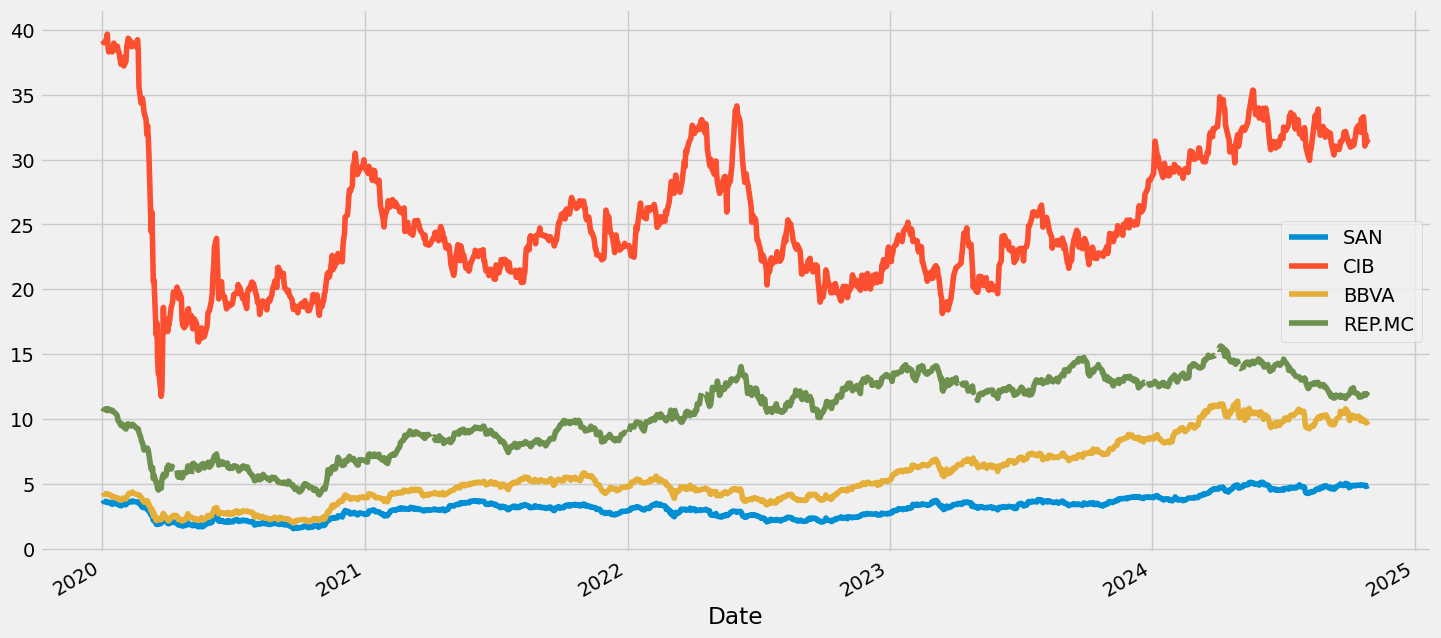

In [5]:
data.plot(figsize=(16,8))
plt.show()

Tenemos problemas por que el REP.MC tiene valores nulos

## Portfolio

### Retorno Simple

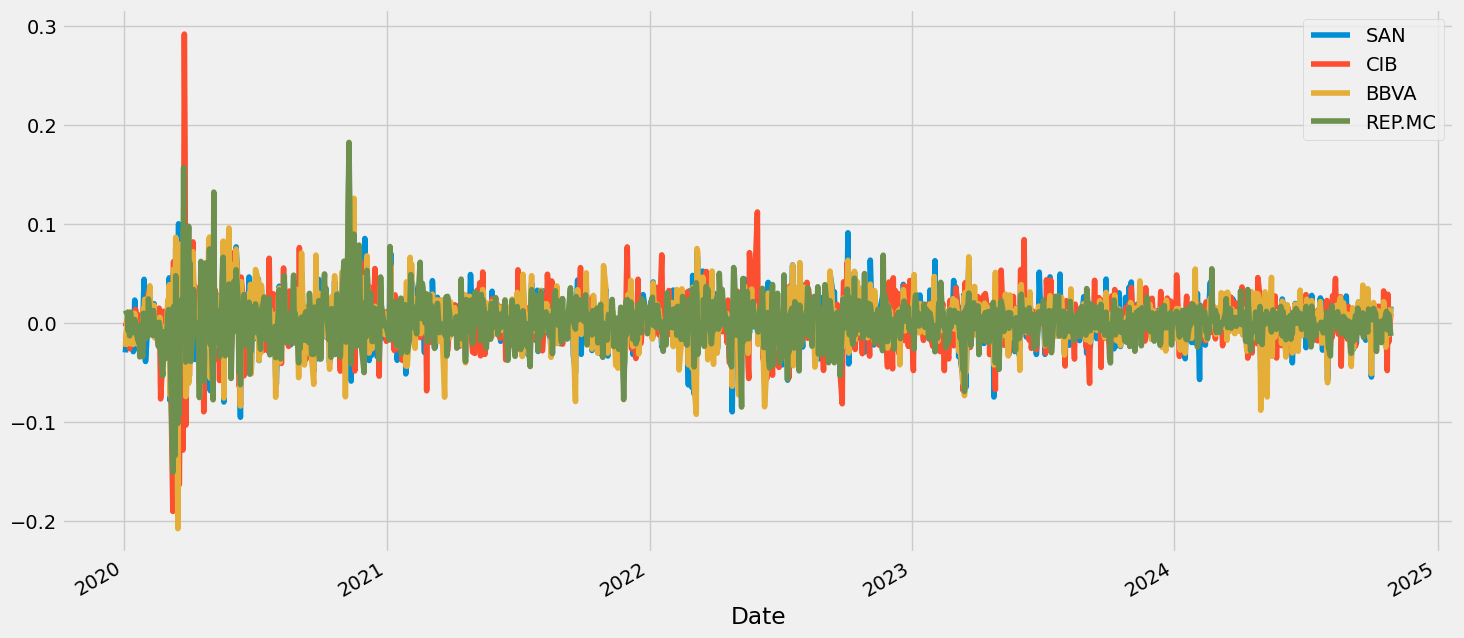

In [6]:
#Retorno simple
ret_simple=data.pct_change().dropna()
ret_simple.plot(figsize=(16,8))
plt.show()

### Retorno Logaritmico

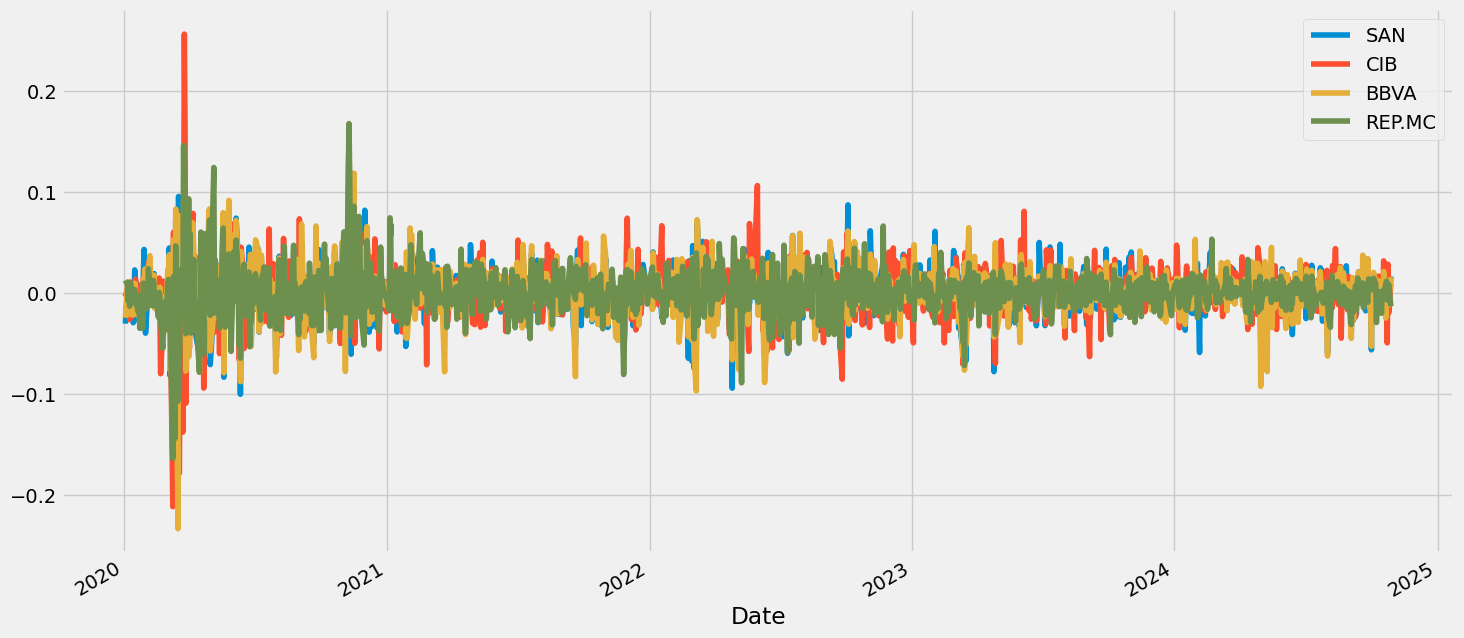

In [7]:
ret_log=np.log(data).diff().dropna()
ret_log.plot(figsize=(16,8))
plt.show()

### Rentabilidad

In [8]:
pesos= [0.25,0.25,0.25,0.25]
rentabilidad_portafolio=np.dot(ret_simple.mean()*252,pesos)

### Riesgos

In [9]:
riesgo_portafolio=np.sqrt(np.dot(np.transpose(pesos),np.dot(ret_log.cov()*252,pesos)))

In [10]:
print('Rentabilidad del portafolio:',rentabilidad_portafolio)
print('Riesgo del portafolio:',riesgo_portafolio)

Rentabilidad del portafolio: 0.13244628224690677
Riesgo del portafolio: 0.3280849178752307


# Modelos

## Tratamiento de datos

In [11]:
data_pronostico = data.asfreq('D').ffill()

In [12]:
data_pronostico.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2020-01-02 00:00:00+00:00 to 2024-10-28 00:00:00+00:00
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SAN     1762 non-null   float64
 1   CIB     1762 non-null   float64
 2   BBVA    1762 non-null   float64
 3   REP.MC  1762 non-null   float64
dtypes: float64(4)
memory usage: 68.8 KB


Como se observa ya tenemos todos los datos completos

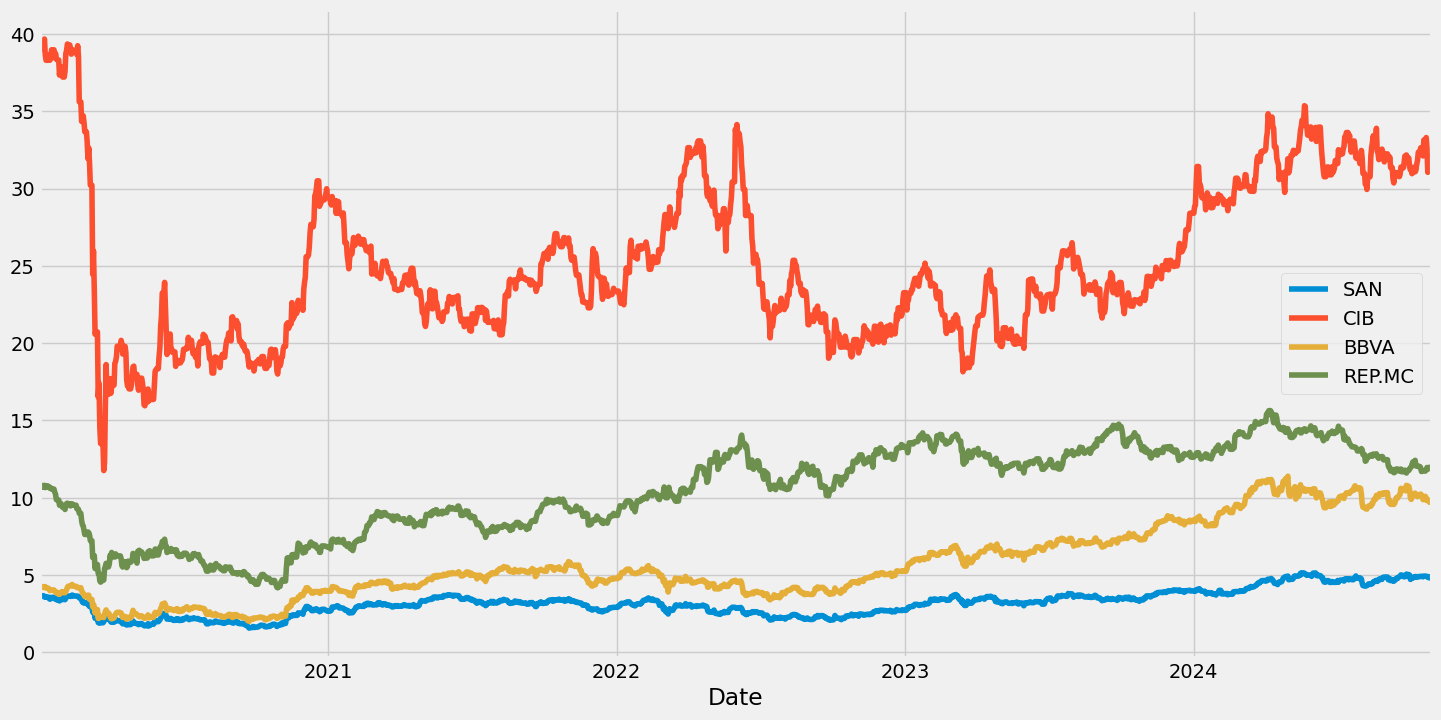

In [13]:
data_pronostico.plot(figsize=(16,8))
plt.show()

## Modelo RandomForest

### SAN Model

### CIB Model

### BBVA Model

### REP.MC

## LSTM

In [14]:
steps=40
def modelo_lstm():
    modelo=Sequential()
    modelo.add(LSTM(steps,input_shape=(1,steps),activation='tanh'))
    modelo.add(Flatten())
    modelo.add(Dense(1,activation='tanh'))
    modelo.compile(loss='mean_absolute_error',optimizer="Adam",metrics = ['mae'])
    modelo.summary()

    return modelo

In [15]:
def serie_a_supervisado(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    #Secuencia de entrada (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    #Secuencia de pronósticos (t, t+1, ... ,t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    #Agregar los frames
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    #Eliminar filas con datos nulos
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [16]:
def agregar_valor(X_test,nuevo_valor):
    for i in range(X_test.shape[2]-1):
        X_test[0][0][i]=X_test[0][0][i+1]
    X_test[0][0][X_test.shape[2]-1]=nuevo_valor
    return X_test

In [17]:
def procesar_y_predecir(data_pronostico, columna, steps=1):
    # Configurar los valores de la columna específica y normalizar
    values = data_pronostico[columna].values.astype('float64')
    scaler = MinMaxScaler()
    values = values.reshape(-1, 1)
    scaled_values = scaler.fit_transform(values)

    # Reestructurar los datos a un formato supervisado
    reframed_data = serie_a_supervisado(scaled_values, steps, 1)

    # Dividir en conjuntos de entrenamiento y prueba
    n_train_days = round(reframed_data.shape[0] * 0.7)
    values = reframed_data.values
    train, test = values[:n_train_days, :], values[n_train_days:, :]

    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]

    # Reformatear a tensores de 3 dimensiones
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Crear y entrenar el modelo LSTM
    modelo = modelo_lstm()
    historia = modelo.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), batch_size=steps)

    # Predecir y graficar los resultados de validación
    results = modelo.predict(X_test)
    plt.plot(y_test, c='g', label='Datos de Validación')
    plt.plot(results, c='b', label='Predicciones')
    plt.legend()
    plt.title(f'Predicciones vs Datos de Validación para {columna}')
    plt.show()

    error = mean_absolute_error(y_test, results)
    print(f"Error Medio Absoluto para {columna}: {error}")

    # Pronóstico para los próximos 60 días
    last_data = data_pronostico[columna]['2024-08-28':].values.astype('float64').reshape(-1, 1)
    scaled_forecast = scaler.transform(last_data)
    reframed_forecast = serie_a_supervisado(scaled_forecast, steps, 1)

    # Eliminar la última columna para usarla como entrada del modelo
    reframed_forecast.drop(reframed_forecast[['var1(t)']],axis=1,inplace=True)

    values=reframed_forecast.values
    x_test=values[reframed_forecast.shape[0]-1:,:]
    x_test=x_test.reshape((1, 1, x_test.shape[1]))

    # Generar la serie de pronóstico
    result_forecast = []
    for _ in range(60):
        parcial = modelo.predict(x_test)
        result_forecast.append(parcial[0])
        x_test = agregar_valor(x_test, parcial[0])

    # Invertir la normalización y graficar el pronóstico
    valores = np.array(result_forecast).reshape(-1, 1)
    inverse = scaler.inverse_transform(valores)
    plt.plot(inverse)
    plt.title(f'Pronóstico a 60 días para {columna}')
    plt.show()

### SAN Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1367 - mae: 0.1367 - val_loss: 0.1578 - val_mae: 0.1578
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0471 - mae: 0.0471 - val_loss: 0.0995 - val_mae: 0.0995
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0902 - val_mae: 0.0902
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0769 - val_mae: 0.0769
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0806 - val_mae: 0.0806
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0767 - val_mae: 0.0767
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0725 - val_mae: 0.0725
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0711 - val_mae: 0.0711
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0202 - mae: 

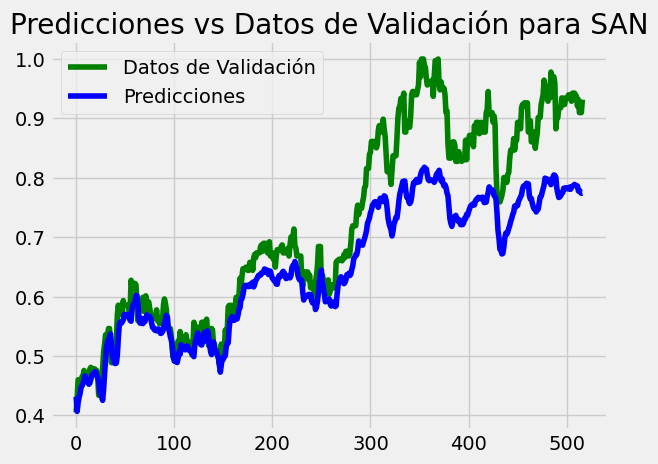

Error Medio Absoluto para SAN: 0.0720174434988452
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


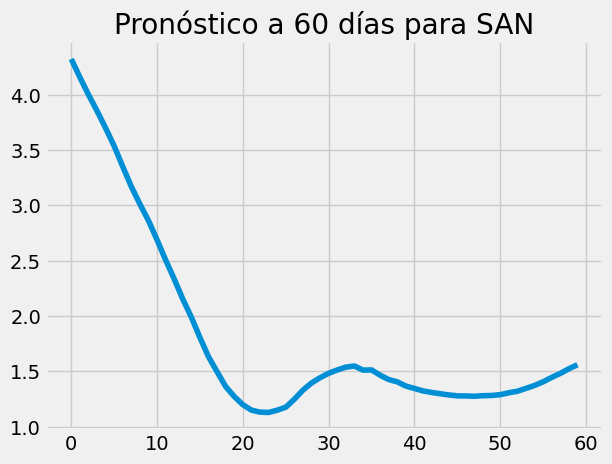

In [18]:
procesar_y_predecir(data_pronostico, 'SAN', steps=40)

### CIB Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1100 - mae: 0.1100 - val_loss: 0.0690 - val_mae: 0.0690
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0488 - mae: 0.0488 - val_loss: 0.0573 - val_mae: 0.0573
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0398 - mae: 0.0398 - val_loss: 0.0536 - val_mae: 0.0536
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0259 - val_mae: 0.0259
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0283 - val_mae: 0.0283
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0237 - val_mae: 0.0237
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0248 - val_mae: 0.0248
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0233 - mae: 

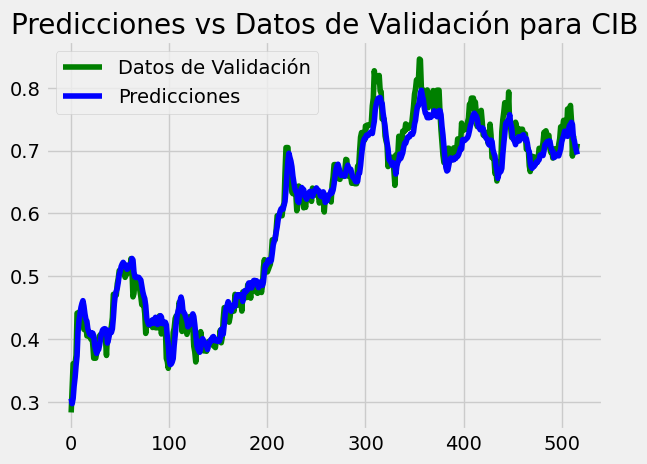

Error Medio Absoluto para CIB: 0.01593465397639089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

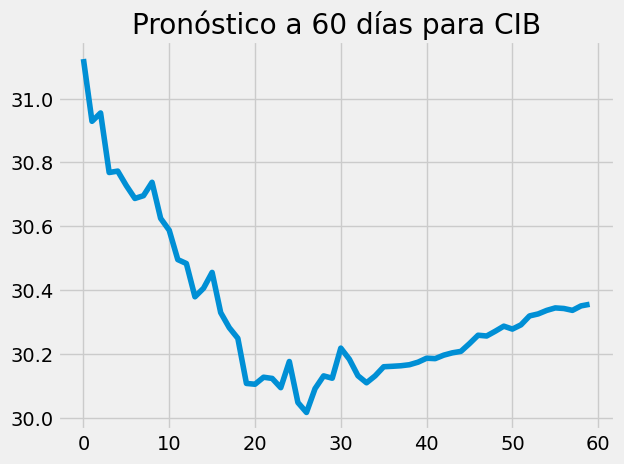

In [19]:
procesar_y_predecir(data_pronostico, 'CIB', steps=40)

### BBVA Model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1390 - mae: 0.1390 - val_loss: 0.1422 - val_mae: 0.1422
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0767 - val_mae: 0.0767
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0759 - val_mae: 0.0759
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0786 - val_mae: 0.0786
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0767 - val_mae: 0.0767
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - mae: 0.0161 - val_loss: 0.0742 - val_mae: 0.0742
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0705 - val_mae: 0.0705
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0668 - val_mae: 0.0668
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - mae: 

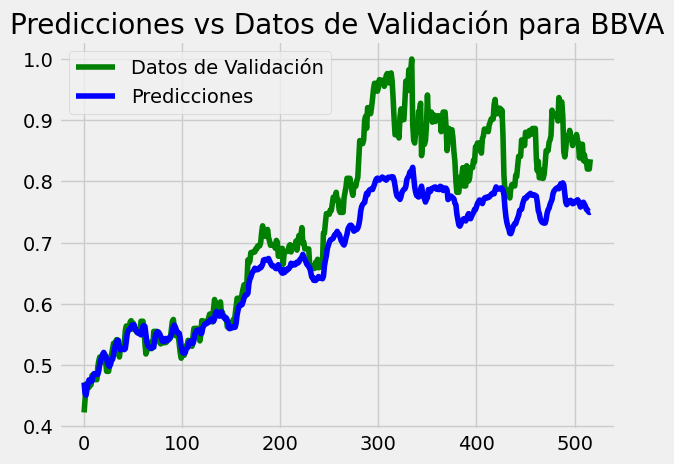

Error Medio Absoluto para BBVA: 0.060459175205891086
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

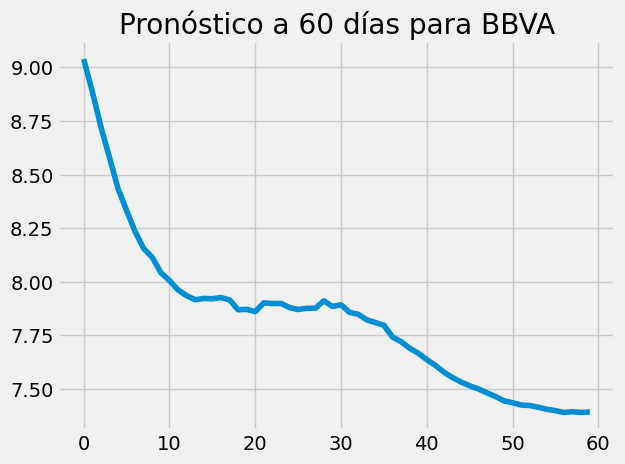

In [20]:
procesar_y_predecir(data_pronostico, 'BBVA', steps=40)

### REP.MC Model

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2669 - mae: 0.2669 - val_loss: 0.0757 - val_mae: 0.0757
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0587 - mae: 0.0587 - val_loss: 0.0690 - val_mae: 0.0690
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0464 - mae: 0.0464 - val_loss: 0.0483 - val_mae: 0.0483
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0462 - val_mae: 0.0462
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0434 - val_mae: 0.0434
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250 - mae:

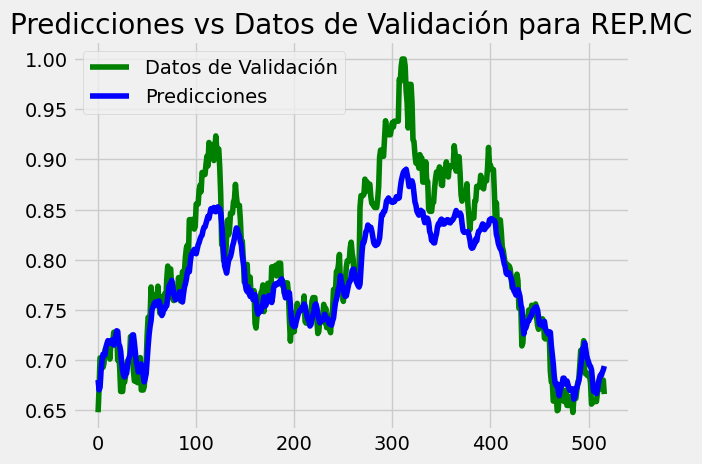

Error Medio Absoluto para REP.MC: 0.026423725856095794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

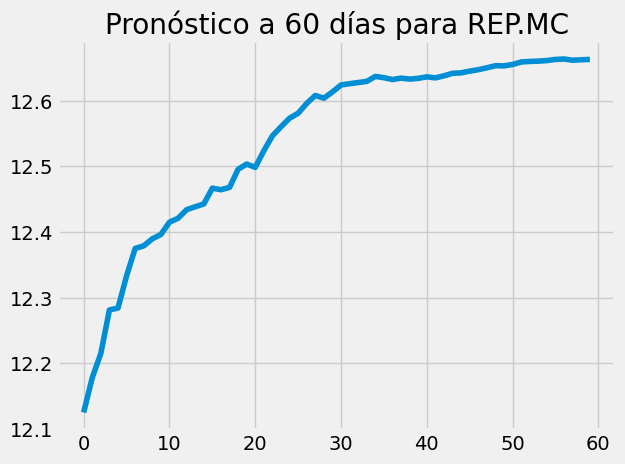

In [21]:
procesar_y_predecir(data_pronostico, 'REP.MC', steps=40)